# TPS MAY 22

> For this challenge, you are given (simulated) manufacturing control data and are tasked to predict whether the machine is in state 0 or state 1. The data has various feature interactions that may be important in determining the machine state.

This notebook includes:

- A brief EDA to get familar with the dataset
- Feature engineering:
    - Dealing with the f_27 column by
    - Introducing the unique_characters feature
    - Adding 3 interaction features as implemented in [AmbrosM](https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras) - inspired by [wti200](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap)
- Implementing a LightGBM model using LGBMs sklearn API 
- k-fold validation to estimate performance
- Basic feature importance estimation
- Inference on test data
- A note on ROC AUC score

My full EDA can be found at: https://www.kaggle.com/code/cabaxiom/tps-may-22-in-depth-eda-feature-engineering

My notebook visualising feature interactions using target value: https://www.kaggle.com/code/cabaxiom/tps-may-22-visualising-feature-interaction


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
train_df = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv")
test_df = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv")

In [3]:
display(train_df.head())
display(test_df.head())

id      f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
0   0 -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326  0.113133   
1   1  1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175  0.447825   
2   2  1.681726  0.616746 -1.027689  0.810492 -0.609086  0.113965 -0.708660   
3   3 -0.118172 -0.587835 -0.804638  2.086822  0.371005 -0.128831 -0.282575   
4   4  1.148481 -0.176567 -0.664871 -1.101343  0.467875  0.500117  0.407515   

   f_07  f_08  ...      f_22      f_23      f_24      f_25      f_26  \
0     1     5  ... -2.540739  0.766952 -2.730628 -0.208177  1.363402   
1     1     3  ...  2.278315 -0.633658 -1.217077 -3.782194 -0.058316   
2     1     0  ... -1.385775 -0.520558 -0.009121  2.788536 -3.703488   
3     3     2  ...  0.572594 -1.653213  1.686035 -2.533098 -0.608601   
4     3     3  ... -3.912929 -1.430366  2.127649 -3.306784  4.371371   

         f_27        f_28  f_29  f_30  target  
0  ABABDADBAB   67.609153     0     0       0  
1  ACACCADCEB  377.096415     0     0       1  
2  AAAEABCKAD -195.599702     0     2       1  
3  BDBBAACBCB  210.826205     0     0       1  
4  BDBCBBCHFE -217.211798     0     1       1  

[5 rows x 33 columns]

id      f_00      f_01      f_02      f_03      f_04      f_05  \
0  900000  0.442517  0.174380 -0.999816  0.762741  0.186778 -1.074775   
1  900001 -0.605598 -0.305715  0.627667 -0.578898 -1.750931  1.355550   
2  900002  0.303990  2.445110  0.246515  0.818248  0.359731 -1.331845   
3  900003  0.154053  0.260126 -1.367092 -0.093175 -1.111034 -0.948481   
4  900004 -1.651904 -0.424266 -0.667356 -0.322124 -0.089462  0.181705   

       f_06  f_07  f_08  ...      f_21      f_22      f_23      f_24  \
0  0.501888     6     6  ... -1.006400 -1.193879 -2.435736 -2.427430   
1 -0.190911     1     3  ...  2.382405  0.149442  1.883322 -2.848714   
2  1.358622     3     3  ... -7.026098  1.312277 -5.157192  1.714005   
3  1.119220     0     0  ... -0.594532 -3.939475  1.754570 -2.364007   
4  1.784983     2     2  ...  0.084906 -0.985736 -0.130467 -3.557893   

       f_25      f_26        f_27        f_28  f_29  f_30  
0 -1.966887  5.734205  BAAABADLAC   99.478419     0     0  
1 -0.725155  3.194219  AFABBAEGCB  -65.993825     1     0  
2  0.585032  0.066898  BBACABBKEE  -87.405622     0     1  
3 -1.003320  3.893099  AEBEAACQCC -281.293460     0     0  
4  1.210687  1.861884  AEBBBBDABF   25.629415     0     2  

[5 rows x 32 columns]

In [4]:
print(train_df.shape)
print(test_df.shape)
train_df.info()

(900000, 33)
(700000, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-nul

## Target

In [5]:
def val_count_df(df, column_name, sort=True):
    value_count = df[column_name].value_counts(sort=sort).reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(sort=sort,normalize=True)*100
    value_count = value_count.reset_index()
    return value_count

target  Value Count  Percentage
0       0       462161   51.351222
1       1       437839   48.648778

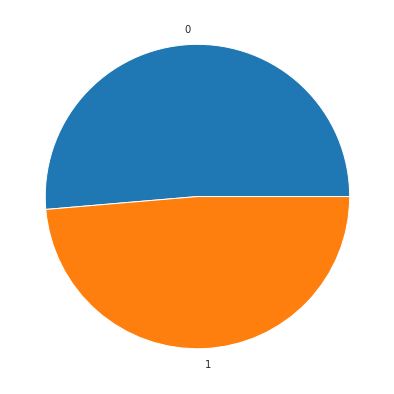

In [6]:
target_count = val_count_df(train_df, "target")
display(target_count)
target_count.set_index("target").plot.pie(y="Value Count", figsize=(10,7), legend=False, ylabel="");

## Features

In [7]:
feature_cols = [col for col in train_df.columns if "f_" in col]
dtype_cols = [train_df[i].dtype for i in feature_cols]
dtypes = pd.DataFrame({"features":feature_cols, "dtype":dtype_cols})
float_cols = dtypes.loc[dtypes["dtype"] == "float64", "features"].values.tolist()
int_cols = dtypes.loc[dtypes["dtype"] == "int64", "features"].values.tolist()

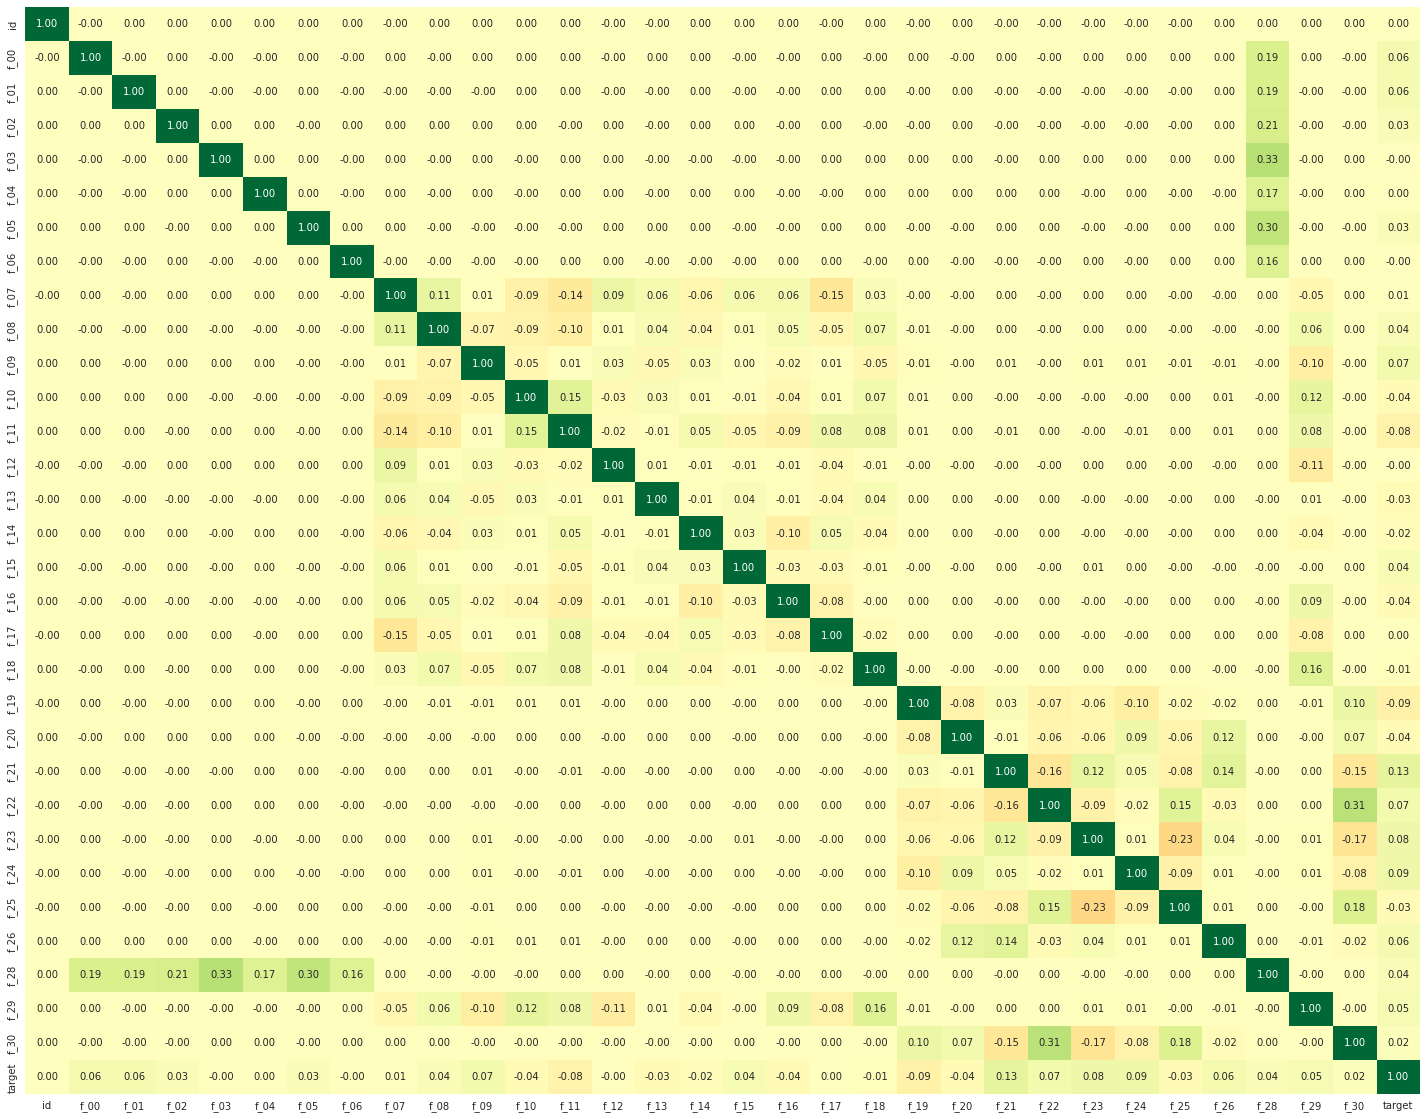

In [8]:
plt.subplots(figsize=(25,20))
sns.heatmap(train_df.corr(),annot=True, cmap="RdYlGn", fmt = '0.2f', vmin=-1, vmax=1, cbar=False);

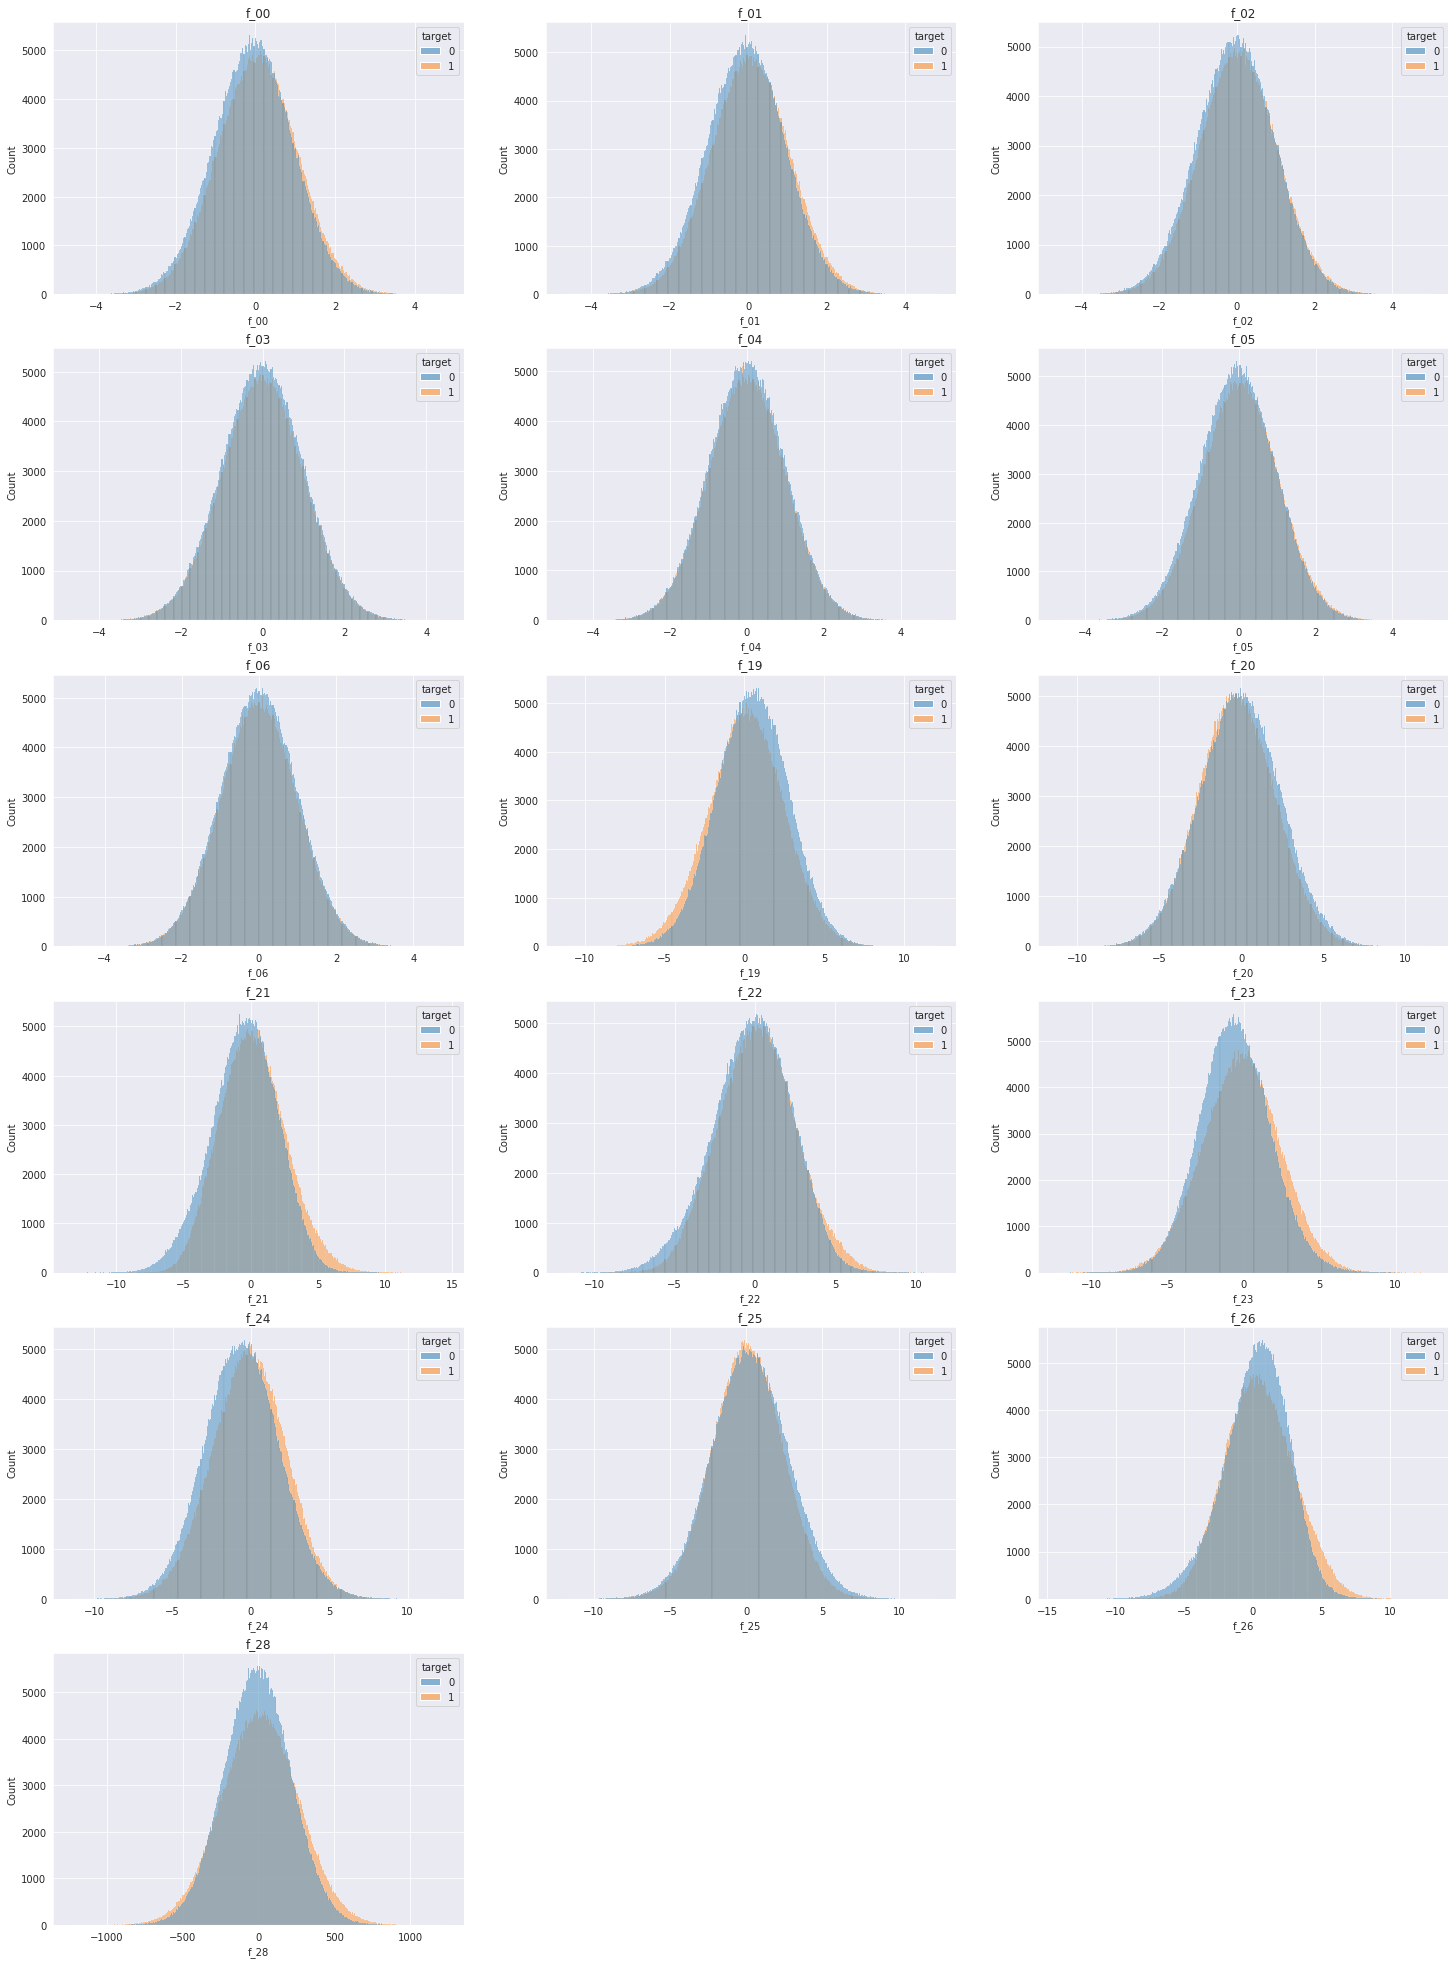

In [9]:
plt.subplots(figsize=(25,35))
for i, column in enumerate(float_cols):
    plt.subplot(6,3,i+1)
    sns.histplot(data=train_df, x=column, hue="target")
    plt.title(column)

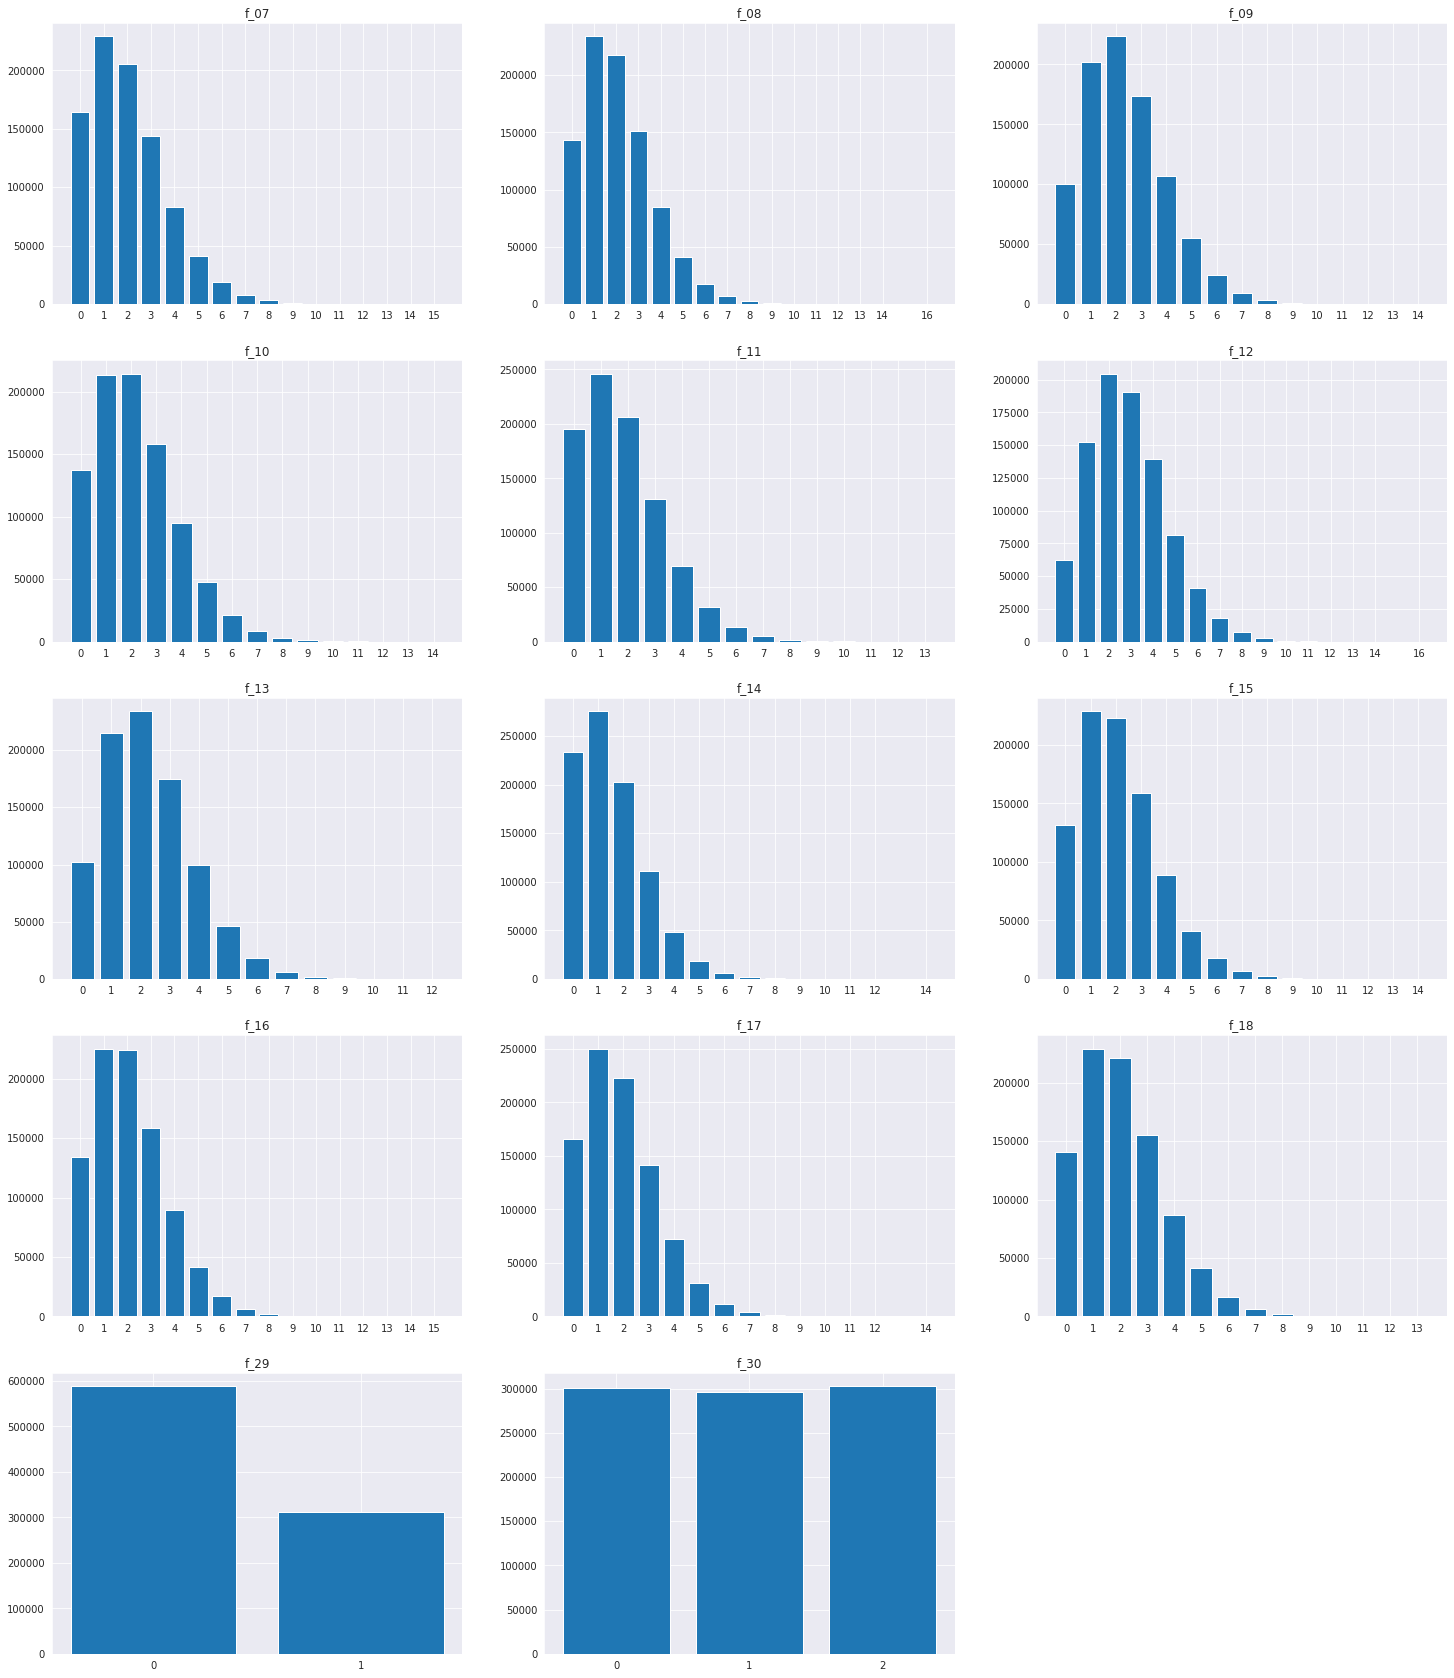

In [10]:
plt.subplots(figsize=(25,30))
for i, column in enumerate(int_cols):
    val_count = train_df[column].value_counts()
    ax = plt.subplot(5,3,i+1)
    #sns.barplot(x=val_count.index,y=val_count.values)
    ax.bar(val_count.index, val_count.values)
    ax.set_xticks(val_count.index)
    plt.title(column)

## f_27

9000000


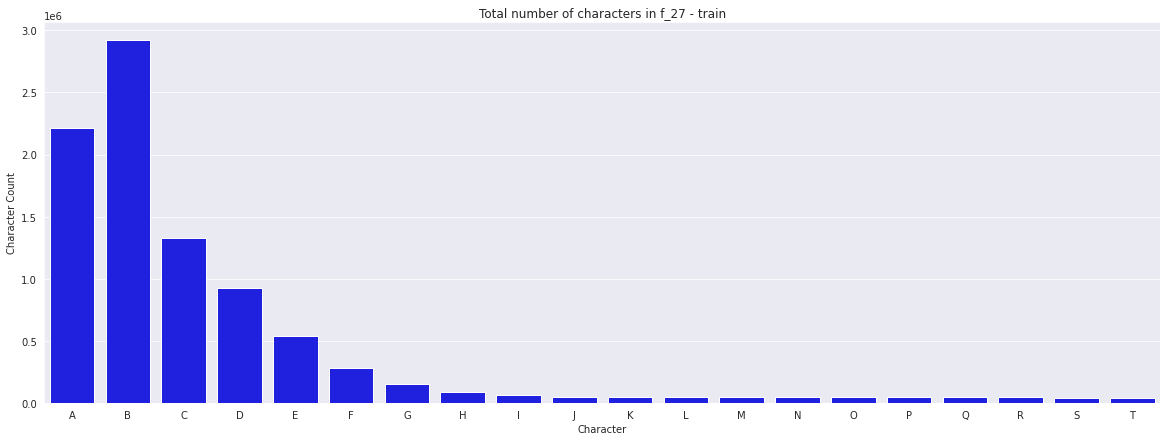

In [11]:
import string
alphabet_upper = list(string.ascii_uppercase)

char_counts = []
for character in alphabet_upper:
    char_counts.append(train_df["f_27"].str.count(character).sum())
char_counts_df = pd.DataFrame({"Character": alphabet_upper, "Character Count": char_counts})
char_counts_df = char_counts_df.loc[char_counts_df["Character Count"] > 0]
print(np.sum(char_counts)) #No other hidden characters

plt.subplots(figsize=(20,7))
sns.barplot(data = char_counts_df, x="Character", y="Character Count", color="blue");
plt.title("Total number of characters in f_27 - train");

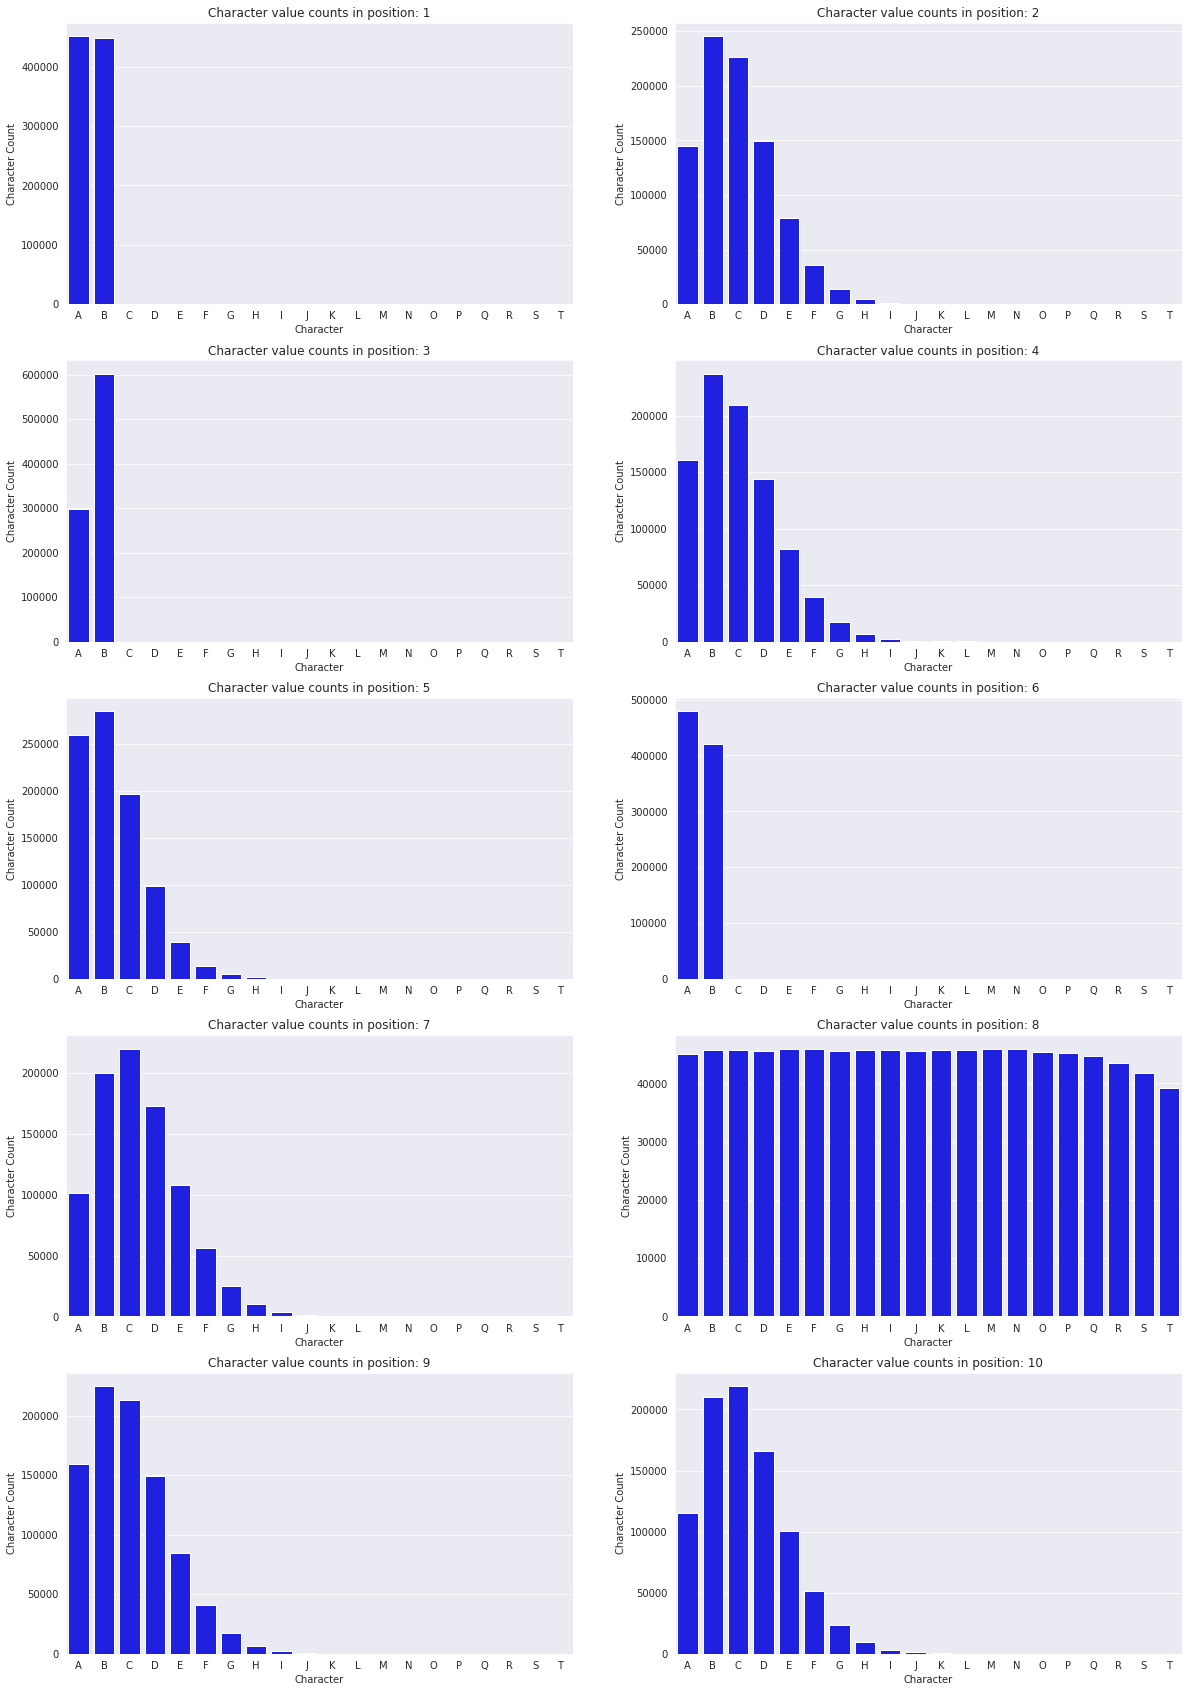

In [12]:
char_counts_df = char_counts_df.set_index("Character", drop=False)
for i in range(10):
    char_counts_df["character"+str(i+1)] = train_df["f_27"].str[i].value_counts()
char_counts_df = char_counts_df.fillna(0)


f,ax = plt.subplots(figsize=(20,30))
character_cols = [i for i in char_counts_df.columns if "character" in i]
for i, column in enumerate(character_cols):
    ax = plt.subplot(5,2,i+1)
    ax = sns.barplot(data = char_counts_df, x="Character", y=column, color="blue");
    plt.title("Character value counts in position: " +str(i+1));
    ax.set_ylabel("Character Count")

# Feature Engineering

**In this section I describe, explain and implement newly created features.**


We can use the string from f_27 to create new features.

Firstly we can create a seperate feature for all 10 character positions in f_27. Instead of using the character values it may be more useful to encode the characters ordinally (A=0, B=1, C=2, ...) 

For example the character in the first posititions could be

In [13]:
display(train_df["f_27"].head(5)) #f_27 column
display(train_df["f_27"].str[0].head(5)) # character is position 1
display(train_df["f_27"].str[0].apply(lambda x: ord(x) - ord("A")).head(5)) # Encode the characters ordinally

0    ABABDADBAB
1    ACACCADCEB
2    AAAEABCKAD
3    BDBBAACBCB
4    BDBCBBCHFE
Name: f_27, dtype: object

0    A
1    A
2    A
3    B
4    B
Name: f_27, dtype: object

0    0
1    0
2    0
3    1
4    1
Name: f_27, dtype: int64

Another important feature I found is the number of unique characters for the f_27 string. Forr example "AABAABAABA" has 2 unique characters ("A" and "B").

In [14]:
display(train_df["f_27"].head(5)) #f_27 column
train_df["f_27"].apply(lambda x: len(set(x))).head(5) #number of unique characters

0    ABABDADBAB
1    ACACCADCEB
2    AAAEABCKAD
3    BDBBAACBCB
4    BDBCBBCHFE
Name: f_27, dtype: object

0    3
1    5
2    6
3    4
4    6
Name: f_27, dtype: int64

There are also some important interaction features as first shown by AmbrosM ([View](https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras/notebook)) whose work was inspired by wti200's [Notebook](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap).

We can view these important interactions in a simple scatter plot:

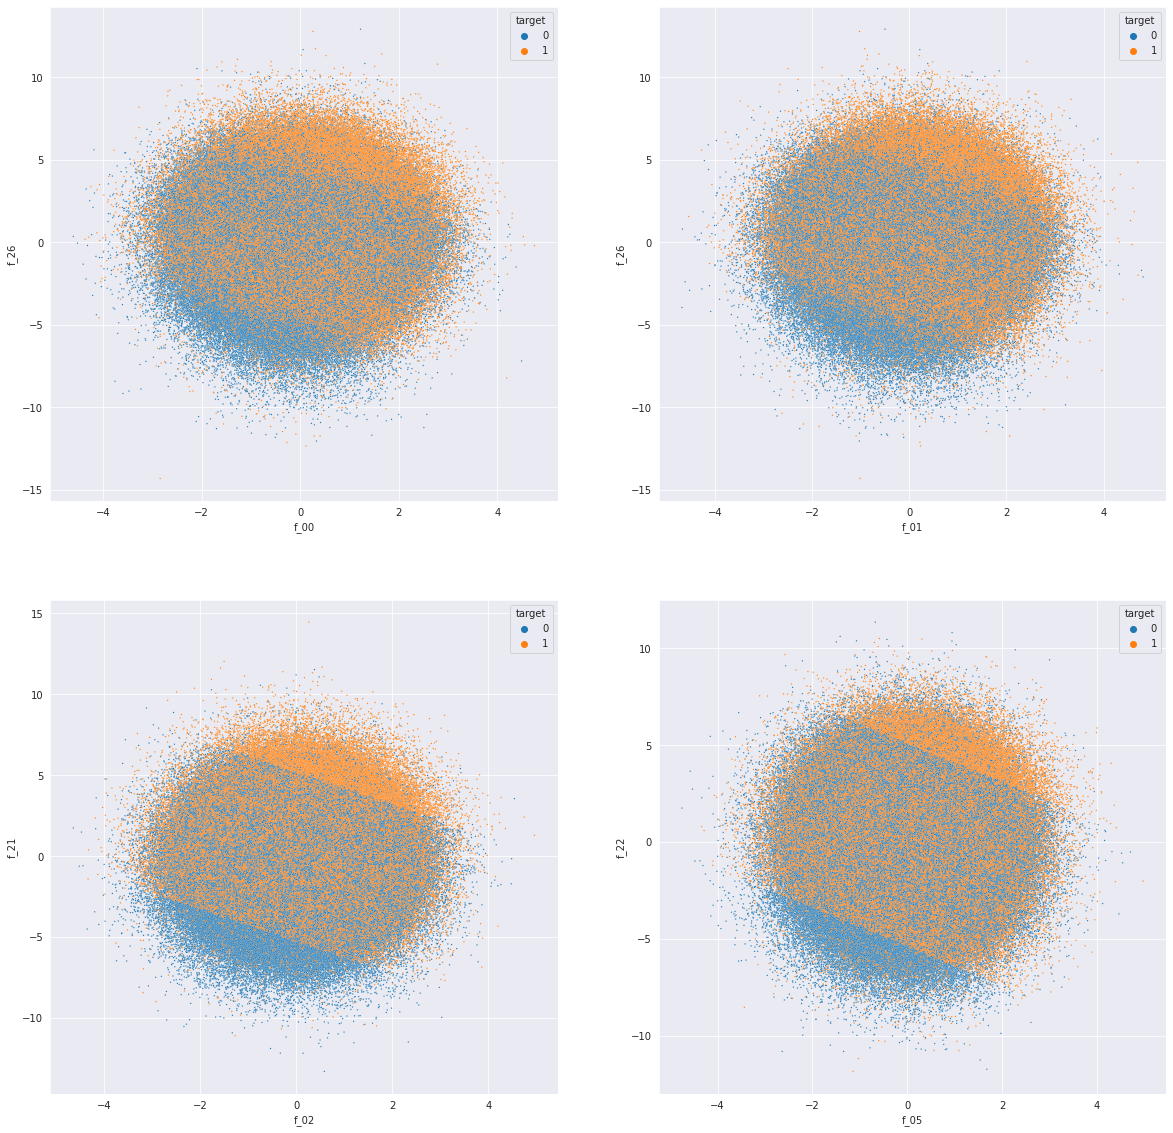

In [15]:
f,ax = plt.subplots(figsize=(20,20))

plt.subplot(2,2,1)
sns.scatterplot(data = train_df, x="f_00", y="f_26", hue="target", s=2);
plt.subplot(2,2,2)
sns.scatterplot(data = train_df, x="f_01", y="f_26", hue="target", s=2);
plt.subplot(2,2,3)
sns.scatterplot(data = train_df, x="f_02", y="f_21", hue="target", s=2);
plt.subplot(2,2,4)
sns.scatterplot(data = train_df, x="f_05", y="f_22", hue="target", s=2);

We notice the graphs of f_00 vs f_26 and f_01 vs f_26 are very similar. Lets try adding f_00 and f_01 and then plotting against f_26:

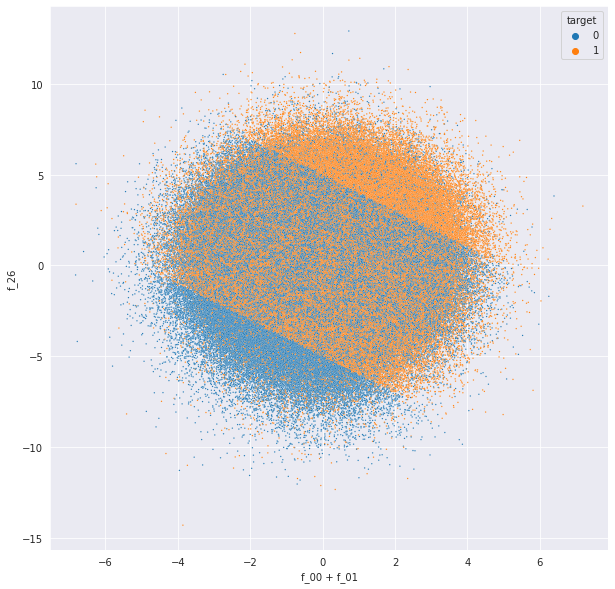

In [16]:
train_df["f_00 + f_01"] =  train_df["f_00"] + train_df["f_01"]
f,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data = train_df, x="f_00 + f_01", y="f_26", hue="target", s=2);

We notice a very unusual interaction creating three very distinct regions for each of these interactions. Lets try adding all involved features together and plotting them against a random number drawn from a normal distribution: 

In [17]:
train_df["f_00 + f_01 + f_26"] = train_df["f_00"] + train_df["f_01"] + train_df["f_26"]
train_df["f_02 + f_21"] = train_df["f_02"] + train_df["f_21"]
train_df["f_05 + f_22"] = train_df["f_05"] + train_df["f_22"]
train_df["random"] = np.random.randn(len(train_df))

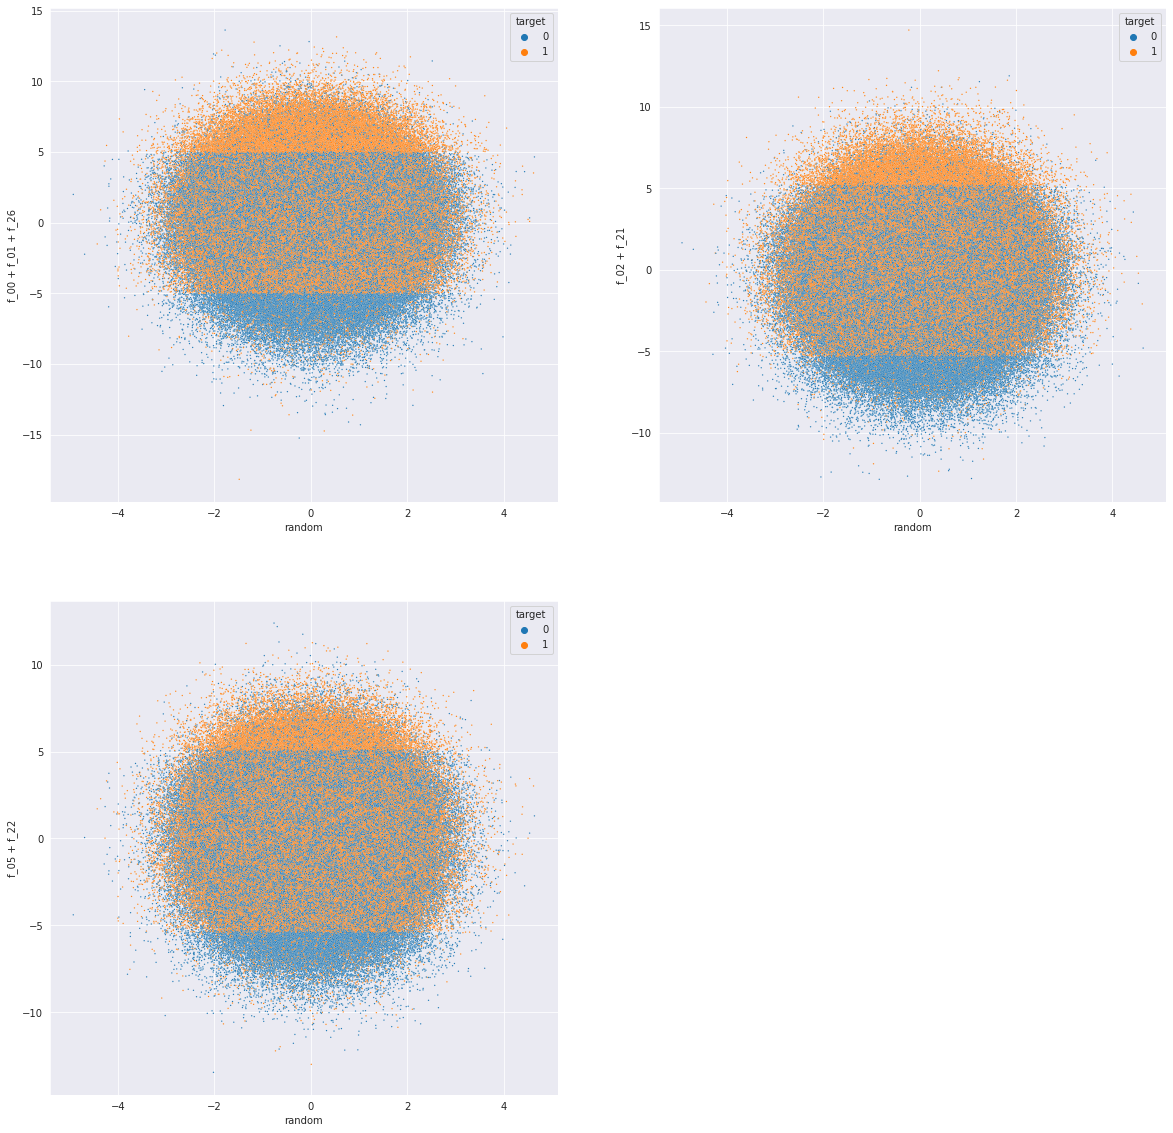

In [18]:
f,ax = plt.subplots(figsize=(20,20))

plt.subplot(2,2,1)
sns.scatterplot(data = train_df, y="f_00 + f_01 + f_26", x="random", hue="target", s=2);
plt.subplot(2,2,2)
sns.scatterplot(data = train_df, y="f_02 + f_21", x="random", hue="target", s=2);
plt.subplot(2,2,3)
sns.scatterplot(data = train_df, y="f_05 + f_22", x="random", hue="target", s=2);

This makes the interaction a lot easier to visualise. We can easily create a feature which returns a value of 1 if the point falls in the top region, a value of 0 if the point falls in the middle region and  and a value of -1 if the point falls in the bottom region. 

For example if f_05 + f_22 > 5.1 then we want a feature that will return 1, and if  f_05 + f_22 < -5.4 return -1 - else return 0. We can do this with the following line from the next cell:

`new_df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)`

We could just use the `f_05 + f_22` as a feature and the model will likely find the boundary but it also helps to explicitly state the boundaries by hand.

If you want to search for more interaction features I have plotted all possible features against each other in the following notebook:

https://www.kaggle.com/code/cabaxiom/tps-may-22-visualising-feature-interaction

In [19]:
def feature_engineer(df):
    new_df = df.copy()
    
    # Interaction features from AmbrosM https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras/notebook
    # Inspired by wti200 https://www.kaggle.com/code/wti200/analysing-interactions-with-shap
    new_df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    new_df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    new_df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
    #Good features
    for i in range(10):
        new_df["f_27_"+str(i)] = new_df["f_27"].str[i].apply(lambda x: ord(x) - ord("A"))
    
    #good feature:
    new_df["unique_characters"] = new_df["f_27"].apply(lambda x: len(set(x)))
    
    new_df = new_df.drop(columns=["f_27", "id"])
    return new_df

In [20]:
%%time
train_df.drop(columns = ["f_00 + f_01", "f_00 + f_01 + f_26", "f_02 + f_21", "f_05 + f_22", "random"], inplace=True) # drop the features we made earlier for demonstration
train_df = feature_engineer(train_df)
test_df = feature_engineer(test_df)

CPU times: user 24 s, sys: 503 ms, total: 24.5 s
Wall time: 24.5 s


In [21]:
train_df["unique_characters"].value_counts()

5    399974
6    220715
4    211165
7     33698
3     32164
8      1185
2      1092
9         6
1         1
Name: unique_characters, dtype: int64

# Model

In [22]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

In [23]:
y = train_df["target"]
X = train_df.drop(columns=["target"])
X_test = test_df
X.head(2)

f_00      f_01      f_02      f_03      f_04      f_05      f_06  f_07  \
0 -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326  0.113133     1   
1  1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175  0.447825     1   

   f_08  f_09  ...  f_27_1  f_27_2  f_27_3  f_27_4  f_27_5  f_27_6  f_27_7  \
0     5     1  ...       1       0       1       3       0       3       1   
1     3     4  ...       2       0       2       2       0       3       2   

   f_27_8  f_27_9  unique_characters  
0       0       1                  3  
1       4       1                  5  

[2 rows x 44 columns]

In [24]:
model = LGBMClassifier(n_estimators = 10000, learning_rate = 0.1, random_state=0, min_child_samples=90, num_leaves=150, max_bins=511, n_jobs=-1)

The variation in roc_auc score across folds is very small - so we save time and use 5-fold cross validation but only evaluate 2 of the 5 folds.

In [25]:
def k_fold_cv(model,X,y):
    kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 0)

    feature_imp, y_pred_list, y_true_list, acc_list, roc_list  = [],[],[],[],[]
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        if fold < 2: # only evaluate 2/5 folds to save time
            print("==fold==", fold)
            X_train = X.loc[train_index]
            X_val = X.loc[val_index]

            y_train = y.loc[train_index]
            y_val = y.loc[val_index]

            model.fit(X_train,y_train)

            y_pred = model.predict_proba(X_val)[:,1]

            y_pred_list = np.append(y_pred_list, y_pred)
            y_true_list = np.append(y_true_list, y_val)

            roc_list.append(roc_auc_score(y_val,y_pred))
            acc_list.append(accuracy_score(y_pred.round(), y_val))
            print("roc auc", roc_auc_score(y_val,y_pred))
            print('Acc', accuracy_score(y_pred.round(), y_val))

            try:
                feature_imp.append(model.feature_importances_)
            except AttributeError: # if model does not have .feature_importances_ attribute
                pass # returns empty list
    return feature_imp, y_pred_list, y_true_list, acc_list, roc_list, X_val, y_val

In [26]:
%%time
feature_imp, y_pred_list, y_true_list, acc_list, roc_list, X_val, y_val = k_fold_cv(model=model,X=X,y=y)

==fold== 0
roc auc 0.996789736899122
Acc 0.9721722222222222
==fold== 1
roc auc 0.9969644950777451
Acc 0.9723833333333334
CPU times: user 2h 36min 53s, sys: 30.6 s, total: 2h 37min 23s
Wall time: 40min 5s


In [27]:
print("Mean accuracy Score:", np.mean(acc_list))
print("Mean ROC AUC Score:", np.mean(roc_list))

Mean accuracy Score: 0.9722777777777778
Mean ROC AUC Score: 0.9968771159884335


In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_cm(preds,true,ax=None):
    cm = confusion_matrix(preds.round(), true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#display_labels 
    disp.plot(ax=ax, colorbar=False, values_format = '.6g')
    plt.grid(False)
    return disp

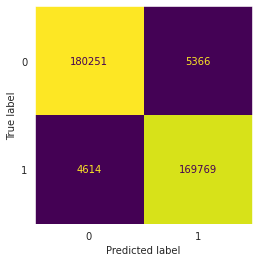

In [29]:
plot_cm(y_pred_list, y_true_list);

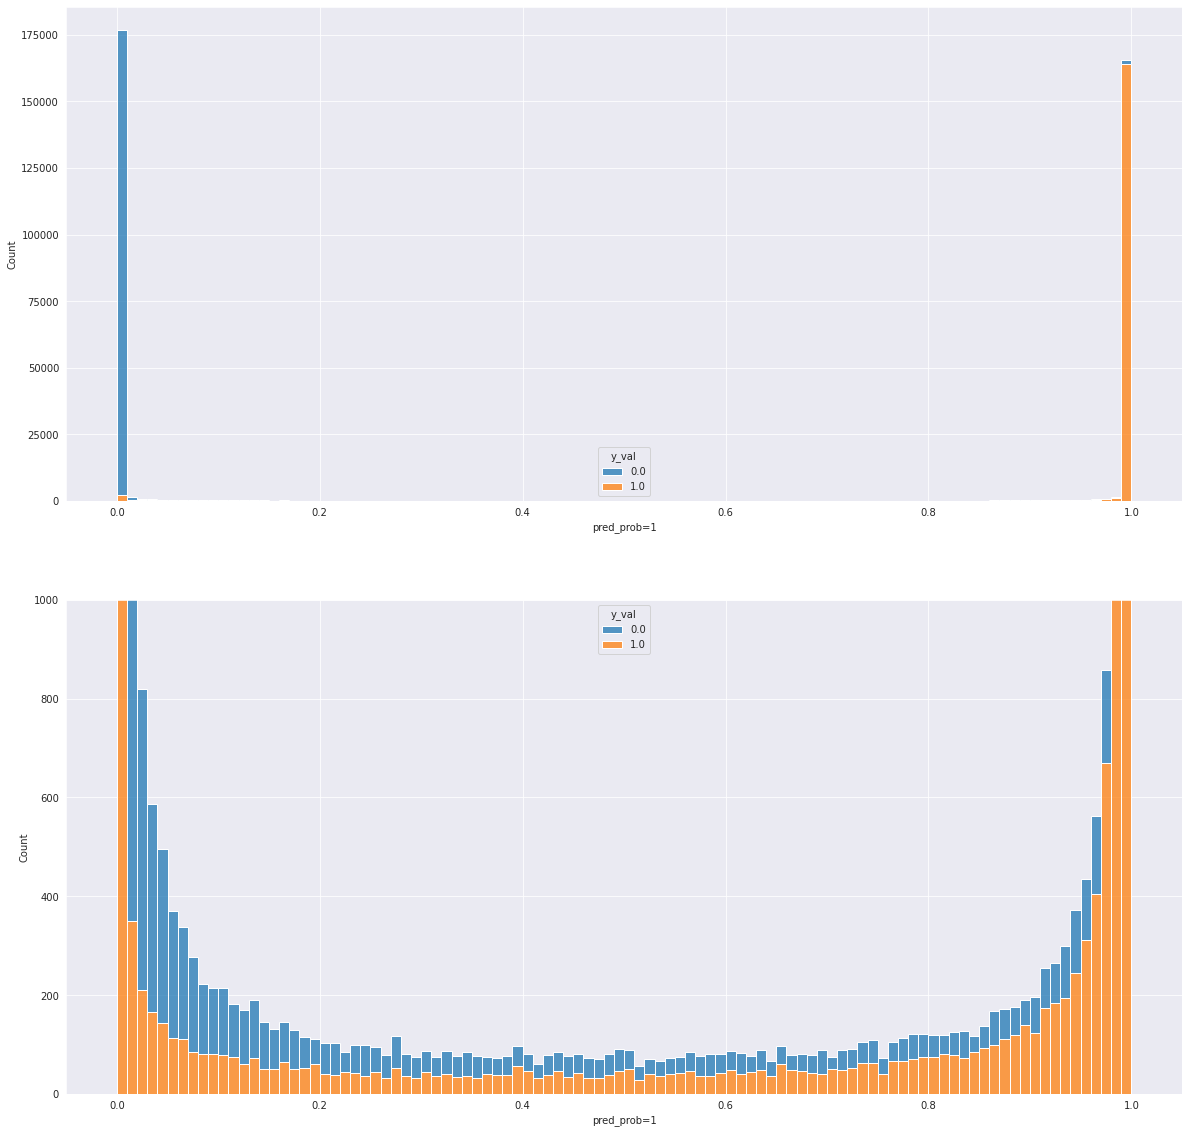

In [30]:
val_preds = pd.DataFrame({"pred_prob=1":y_pred_list, "y_val":y_true_list})
f,ax = plt.subplots(figsize=(20,20))
plt.subplot(2,1,1)
ax = sns.histplot(data=val_preds, x="pred_prob=1", hue="y_val", multiple="stack", bins = 100)
#Same plot "zoomed in"
plt.subplot(2,1,2)
ax = sns.histplot(data=val_preds, x="pred_prob=1", hue="y_val", multiple="stack", bins = 100)
ax.set_ylim([0,1000]);

# Feature Importance

In [31]:
def fold_feature_importances(model_importances, column_names, model_name, n_folds = 5, ax=None, boxplot=False):
    importances_df = pd.DataFrame({"feature_cols": column_names, "importances_fold_0": model_importances[0]})
    for i in range(1,n_folds):
        importances_df["importances_fold_"+str(i)] = model_importances[i]
    importances_df["importances_fold_median"] = importances_df.drop(columns=["feature_cols"]).median(axis=1)
    importances_df = importances_df.sort_values(by="importances_fold_median", ascending=False)
    if ax == None:
        f, ax = plt.subplots(figsize=(15, 25))
    if boxplot == False:
        ax = sns.barplot(data = importances_df, x = "importances_fold_median", y="feature_cols", color="blue")
        ax.set_xlabel("Median Feature importance across all folds");
    elif boxplot == True:
        importances_df = importances_df.drop(columns="importances_fold_median")
        importances_df = importances_df.set_index("feature_cols").stack().reset_index().rename(columns={0:"feature_importance"})
        ax = sns.boxplot(data = importances_df, y = "feature_cols", x="feature_importance", color="blue", orient="h")
        ax.set_xlabel("Feature importance across all folds");
    plt.title(model_name)
    ax.set_ylabel("Feature Columns")
    return ax

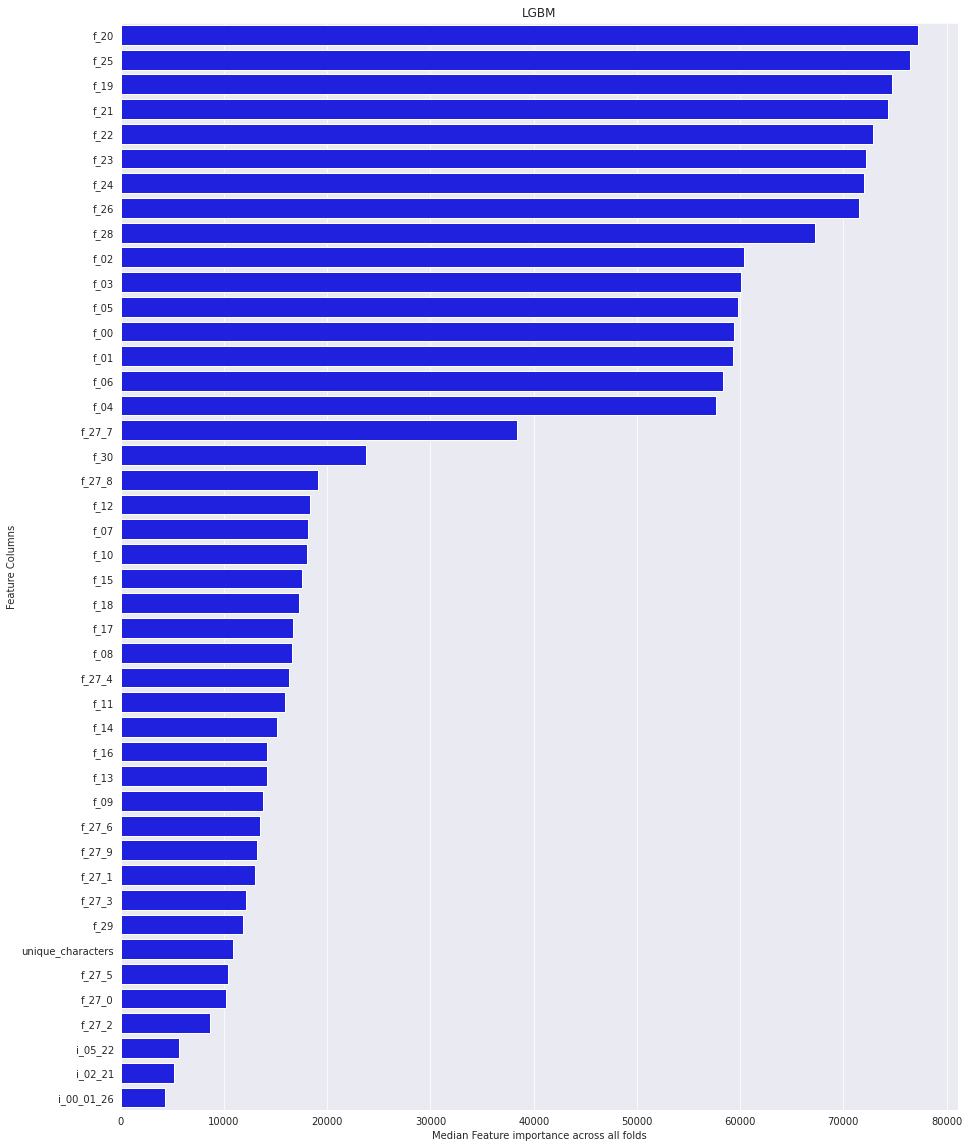

In [32]:
f, ax = plt.subplots(figsize=(15, 20))
fold_feature_importances(model_importances = feature_imp, column_names = X_val.columns, model_name = "LGBM", n_folds = 2, ax=ax, boxplot=False);

# Submission

In [33]:
def pred_test():
    pred_list = []
    for seed in range(5):
        model = LGBMClassifier(n_estimators = 10000, learning_rate = 0.1, min_child_samples=90, num_leaves=150, max_bins=511, random_state=seed, n_jobs=-1)
        model.fit(X,y)

        preds = model.predict_proba(X_test)[:,1]
        pred_list.append(preds)
    return pred_list

In [34]:
pred_list = pred_test()
pred_df = pd.DataFrame(pred_list).T
pred_df = pred_df.rank()
pred_df["mean"] = pred_df.mean(axis=1)
pred_df

0         1         2         3         4      mean
0       591573.5  580480.0  599195.0  588590.5  597814.0  591530.6
1       578858.5  588392.0  594988.0  572866.5  565630.5  580147.1
2        13823.0   16281.0   12344.0   13103.0   15235.0   14157.2
3       134509.0  111877.0  102639.0  142159.0  105496.0  119336.0
4       563872.0  562361.0  565504.0  565360.5  571697.0  565758.9
...          ...       ...       ...       ...       ...       ...
699995  375332.0  369880.0  368807.0  371601.0  359993.0  369122.6
699996  562786.0  571068.0  578302.0  593610.5  560824.5  573318.2
699997  305994.0  296658.0  279222.0  294544.0  294641.0  294211.8
699998  172843.0  149986.0  137175.0  153015.0  141770.0  150957.8
699999     353.0     627.0     353.0     241.0     712.0     457.2

[700000 rows x 6 columns]

In [35]:
sample_sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")
sample_sub["target"] = pred_df["mean"]
sample_sub

id    target
0        900000  591530.6
1        900001  580147.1
2        900002   14157.2
3        900003  119336.0
4        900004  565758.9
...         ...       ...
699995  1599995  369122.6
699996  1599996  573318.2
699997  1599997  294211.8
699998  1599998  150957.8
699999  1599999     457.2

[700000 rows x 2 columns]

**Question:**

If we are predicting probabilities, why do these target scores not fall between 0 and 1?

**Answer:**

The evaluation metric is ROC AUC.

One way of interpreting AUC is: **the probability that the model ranks a random positive example more highly than a random negative example.**

Our model can be used to output the predicted probability. The absolute values of the predictions do not matter - it does not matter how much higher the random positive example is than the random negative example, we are only interested in the rankings between them.

In other words the ROC AUC score is scale invariant. **AUC measures how well the predictions are ranked**.

Therefore we can use the predicted probability ranks rather than the predicted probabilities when calculating the ROC AUC score.


Example:

In [36]:
pred_df = pd.DataFrame(y_pred_list, columns=["pred_prob"])
pred_df["rank"] = pred_df.rank()
display(pred_df.head(10))

print("roc auc using prediction probabilities:", roc_auc_score(y_true_list, pred_df["pred_prob"]))
print("roc auc using predicted probabilities ranks:", roc_auc_score(y_true_list, pred_df["rank"]))

pred_prob      rank
0  1.000000e+00  288303.5
1  1.381719e-13   64294.0
2  2.436079e-09  118222.0
3  5.437286e-11   96911.0
4  4.688428e-10  109221.0
5  7.165396e-05  163647.0
6  6.337654e-13   72101.0
7  9.999999e-01  227440.0
8  1.640788e-12   77181.0
9  9.999991e-01  220125.0

roc auc using prediction probabilities: 0.9968765769944916
roc auc using predicted probabilities ranks: 0.9968765769944916


It may be better to use ranks rather than probabilities as it allows us to combine multiple sets of predictions together without bias towards one set of predictions.

In [37]:
sample_sub.to_csv('submission.csv', index = False)

# Next steps

- Further feature engineering, such as searching for more interaction features - you may find this notebook useful for this: https://www.kaggle.com/code/cabaxiom/tps-may-22-visualising-feature-interaction.
- Hyperparameter tuning.
- Considering using a different Gradient Boosted Decision Tree algorithm (XGBoost, CatBoost, [SKLearn's HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html),  [SKLearn's GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)).
- Consider not using the LightGBMs SKLearn API - LGBMs SKlearns API works well but I find it can be a little less flexible / throws warnings.
- Consider implementing both a GBDT and a NN model e.g. https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras.